In [162]:
import numpy as np
import time
from scipy.special import gammaln
import torch

import scipy.stats as stats
import train_2D_rt_v2 as tr
import tools_2D_rt_v2 as tt

import matplotlib.pyplot as plt

# Generate Data


Make sure you have also copied '/home/mcarilli/CME/2D_CME/learning_environment/train_2D_rt_v1.py' and
'/home/mcarilli/CME/2D_CME/learning_environment/tools_2D_rt_v1.py' to your file location. 


If you want to load in pre-generated data, there are 20 batches of 5,120 are already stored in:


1. '/home/mcarilli/CME/2D_CME/learning_environment/training_data_quadvec/'
2. '/home/mcarilli/CME/2D_CME/learning_environment/training_data_fixedquad/'


There are also 10 batches of 512 parameters in 1 (_fixedquad/_) and 10 batches of 256 parameterc in 2 (_quadvec/_). 
generated using quad_vec and fixed_quad, respectively. 


If you want to make and store other data files, here is some code:

In [163]:
# define your data path

path =  '/home/mcarilli/CME/2D_CME/learning_environment/training_data_quadvec/'

In [164]:
set_size = 256
num_files = 10
N = num_files*set_size


params = tr.generate_param_vectors(N)

In [ ]:
# define your xmax function!! 

def xmax_fun(xmax):

    return(4.5*xmax)

In [ ]:
#generate_sets(set_size,num_files,param_vectors,method,xmax_fun,NCOR,path_to_directory)
tr.generate_sets_pcme(set_size = 256,num_files=num_files,param_vectors = params,
                 method = 'quad_vec',
                 xmax_fun=xmax_fun,
                 NCOR = 60,
                 path_to_directory=path)

# Train ! 


Here are the generating grid and get_ypred_at_RT functions! 


You can choose to generate the grid using NORM_nas, NORM_mat quantiles (linear right now, rectangular grid), or performin an affine transform with the covariance matrix and means. 

To change, merely change the generate_grid function in get_ypred_at_RT. 

In [186]:
def generate_grid(npdf,VAR,MU,p,quantiles=None):
    
    if quantiles=='PRESET':
        logstd = torch.sqrt(torch.log((VAR/MU**2)+1))
        logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))
        translin_0 = torch.exp(logmean[0]+logstd[0]*NORM_nas)
        translin_1 = torch.exp(logmean[1]+logstd[1]*NORM_mat)
        
        
        GRID_nas,GRID_mat = torch.meshgrid(translin_0,translin_1,indexing='ij')
        
        return GRID_nas,GRID_mat

    
def generate_grid_affine(npdf,VAR,MU,p,quantiles=None):
    
    if quantiles=='PRESET':
        logstd = torch.sqrt(torch.log((VAR/MU**2)+1))
        logvar = logstd**2
        logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))
        
        # calculate sigma_ij
        var_ij = p[0]**2/ (p[1]+p[2]) 
        logst_ij = torch.log( var_ij * np.exp(-(logmean.sum()+logvar.sum()/2)) +1 )

        sig_ii = logvar[0]
        sig_jj = logvar[1]
        sig_ij = logst_ij
        
        xv, yv = torch.meshgrid(NORM_nas,NORM_mat,indexing='ij')
        
        Sig = torch.tensor([[sig_ii,sig_ij],[sig_ij,sig_jj]])
        A = torch.linalg.cholesky(Sig,upper=False)

   
        GRID_nas = torch.exp(A[0,0]*xv+A[1,0]*yv + logmean[0])
        GRID_mat = torch.exp(A[0,1]*xv+A[1,1]*yv + logmean[1])
        
        return GRID_nas,GRID_mat


def get_ypred_at_RT(p,npdf,w,hyp,quantiles='PRESET',
                   first_special=False,special_std='tail_prob'):
    p = 10**p
    MU, VAR, STD, xmax = tr.get_moments(p)
    
    GRID_nas,GRID_mat = generate_grid_affine(npdf,VAR,MU,p,quantiles=quantiles)

    
   
    s_nas = torch.zeros((GRID_nas.shape))
    s_mat =  torch.zeros((GRID_mat.shape))

    spec = 0 if first_special else -1
    if first_special:
        s_nas[1:,:] = torch.diff(GRID_nas,axis=0)
        s_mat[:,1:] = torch.diff(GRID_mat)
    else: #last special... for now
        s_nas[:-1,:] = torch.diff(GRID_nas,axis=0)
        s_mat[:,:-1] = torch.diff(GRID_mat)
    
    if special_std == 'mean':
        s_nas[spec] = GRID_nas[spec]
        s_mat[spec] = GRID_mat[spec]
    elif special_std == 'neighbor': #assign_neighbor_to_special
        s_nas[spec] = s_nas[1] if first_special else s_nas[-2]
        s_mat[spec] = s_mat[1] if first_special else s_mat[-2]
        
    elif special_std == 'tail_prob':
        if first_special:
            print('If you are using this setting, you are doing something wrong.')
        t_max = torch.log(p[1]/p[2])/(p[1] - p[2])
        f = (torch.exp(-p[2]*t_max) - torch.exp(-p[1]*t_max)) * p[1]/(p[1] - p[2]) * p[0]
        tailratio = 1/(1+1/f) #the mature tail ratio
        s_mat[:,spec] = torch.sqrt(GRID_mat[:,spec] / (1-tailratio))
        tailratio = p[0]/(1+p[0]) #the nascent tail ratio
        s_nas[spec,:] = torch.sqrt(GRID_nas[spec,:] / (1-tailratio))
    else:
        print('did not specify a standard deviation convention!')
    
    s_nas *= hyp
    s_mat *= hyp
    v_nas = s_nas**2
    v_mat = s_mat**2

    r_nas = GRID_nas**2/(v_nas-GRID_nas)
    p_nas = 1-GRID_nas/v_nas 
    r_mat = GRID_mat**2/(v_mat-GRID_mat)
    p_mat = 1-GRID_mat/v_mat 
    
    xgrid_nas = torch.arange(xmax[0]+1)
    xgrid_mat = torch.arange(xmax[1]+1)
    
    gammaln_xgrid_nas = lnfactorial[1:(xmax[0]+2)]
    gammaln_xgrid_mat = lnfactorial[1:(xmax[1]+2)] 

    Y = torch.zeros((xmax[0]+1,xmax[1]+1))

    for i in range(npdf[0]):
        for j in range(npdf[1]):
 
            lnas = -GRID_nas[i,j] + xgrid_nas * torch.log(GRID_nas[i,j]) - gammaln_xgrid_nas

            if p_nas[i,j] > 1e-10:
                lnas += torch.special.gammaln(xgrid_nas+r_nas[i,j]) - torch.special.gammaln(r_nas[i,j]) \
                - xgrid_nas*torch.log(r_nas[i,j] + GRID_nas[i,j]) + GRID_nas[i,j] \
                + r_nas[i,j]*torch.log(1-p_nas[i,j])
        
            lmat =  - GRID_mat[i,j] + xgrid_mat * torch.log(GRID_mat[i,j]) - gammaln_xgrid_mat
            if p_mat[i,j] > 1e-10:
                lmat += torch.special.gammaln(xgrid_mat+r_mat[i,j]) - torch.special.gammaln(r_mat[i,j]) \
                - xgrid_mat*torch.log(r_mat[i,j] + GRID_mat[i,j]) + GRID_mat[i,j] \
                + r_mat[i,j]*torch.log(1-p_mat[i,j]) #wasteful: we're recomputing a lot of stuff.
    
            
            Y += w[i*npdf[1] + j] * torch.exp(lnas[:,None] + lmat[None,:])
            #print('Y shape: ',Y.shape)
            #note convention change. Y = the predicted PMF is now returned in the same shape as the original histogram.
            #this is fine bc Y is flattened anyway later on down the line.
    return Y




In [187]:
# define NORM and YPRED_FUN
npdf = np.array([10,10])

if npdf[0] == npdf[1]:
    n = np.arange(npdf[0])
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf[0])*np.pi)+1)/2)
    NORM = stats.norm.ppf(q)
    NORM_nas = torch.tensor(NORM)
    NORM_mat = NORM_nas
else:
    n = np.arange(npdf[0])
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf[0])*np.pi)+1)/2)
    print(q)
    NORM_nas = torch.tensor(stats.norm.ppf(q))
    n = np.arange(npdf[1])
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf[1])*np.pi)+1)/2)
    print(q)
    NORM_mat = torch.tensor(stats.norm.ppf(q))
    
lnfactorial = torch.special.gammaln(torch.arange(1003))

Load in how many training and testing files you want. Get data now also needs set size

In [188]:
train_list, test_list = tr.get_data(set_size = 256,
                                    number_of_training_files=1,
                                 number_of_testing_files=1,total_files=3,file_path=path)

In [181]:
t1 = time.time()
e,b,t,model = tr.train_MLP(train_list[0:20],test_list[0:10],num_epochs=5,
                           npdf=[10,10],batchsize=10,get_ypred_at_RT=get_ypred_at_RT,
                           metric='kld',learning_rate=1e-3,MLP=1)
t2 = time.time()

print(t2-t1)



# IF YOU WANT TO SAVE
#path1 = 'DEFINE/PATH/TO/STORE'
#np.save(path1+'e_t',[e,t])
#torch.save(model.state_dict(),'./test_MODEL')

Epoch Number: 0
Epoch Number: 1
Epoch Number: 2
Epoch Number: 3
Epoch Number: 4
12.334416389465332


In [81]:
#torch.save(model.state_dict(),'./quadvec_models/03172022_20npdf_256params_20e_hyp_MODEL')

# Plotting!


If you have already stored your model, load it in!

In [141]:
# pre-loaded model

#path = './dir_03032022/'
#npdf = [10,11]
#model = tr.my_MLP1(3,npdf[0]*npdf[1])
#model.load_state_dict(torch.load(path+'MODEL_kld'))
#model.eval()
#array = np.load(path+ 'mselog.npy',allow_pickle=True)
#e = array[0]
#t = array[1]

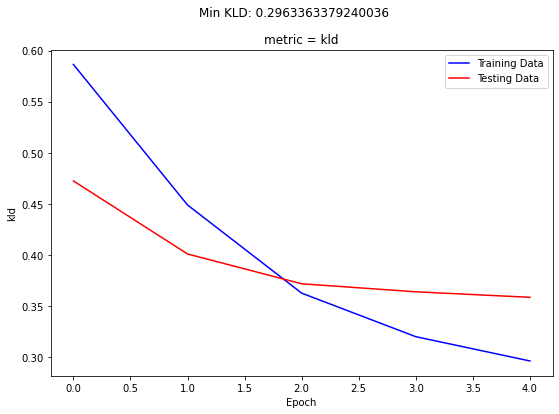

In [182]:
metric = 'kld'

tt.plot_training(e,t,metric)

## Metric Histogram

In [143]:


# i know the function still says test_klds, but now it calculates whatever metric you give it

metrics, metric_mean = tr.calculate_test_metrics(test_list=train_list[0:12],npdf= [10,10],
                                        model=model,get_ypred_at_RT=get_ypred_at_RT_affine,
                                             metric = metric)

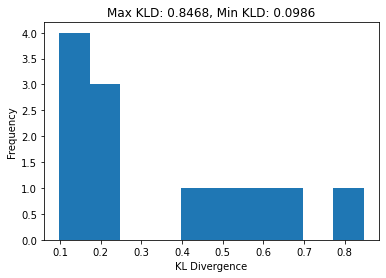

In [144]:
tt.plot_histogram(metrics,bins=10)

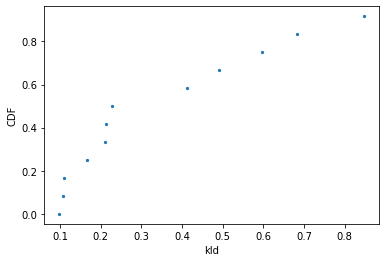

In [145]:
tt.plot_CDF(metrics)

## Plot Param Quantiles

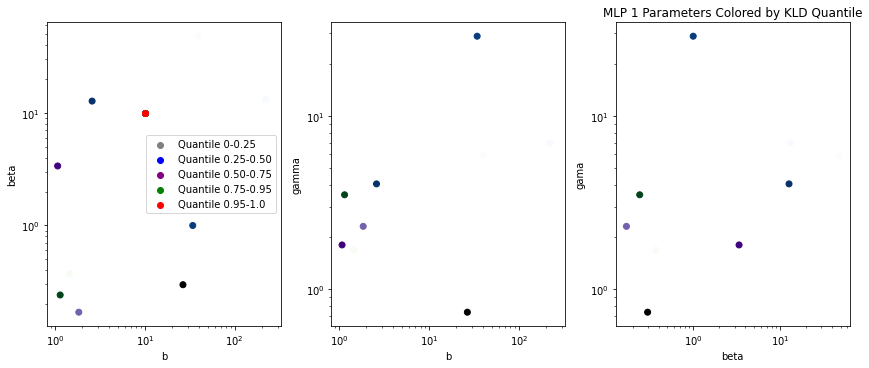

In [147]:
tt.plot_param_quantiles(metrics,train_list[0:12])

## Plot PMFs

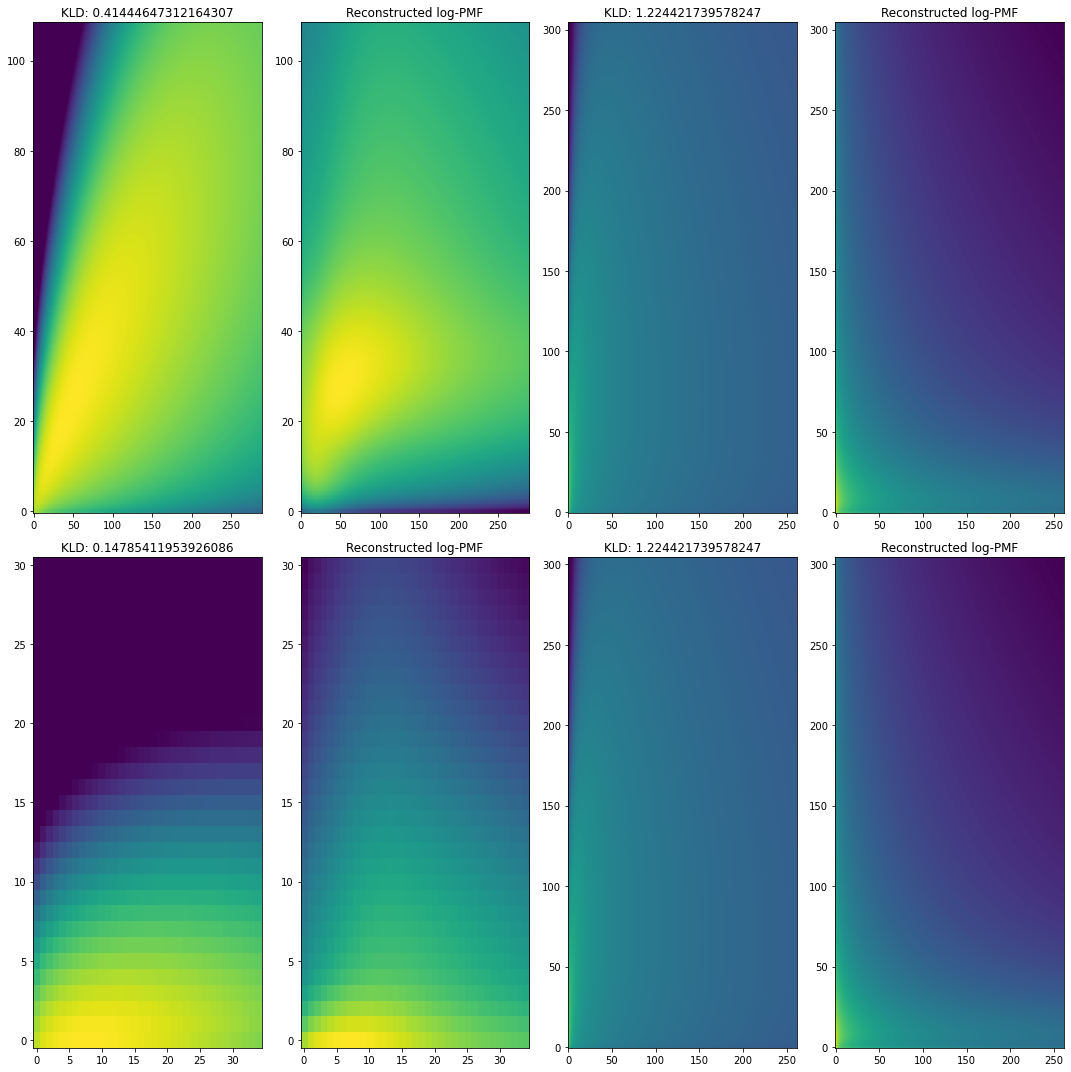

In [185]:
tt.plot_PMF_grid(file_list=train_list[0:10],npdf=[10,10],nrows=2,
                 ncols=2,model=model,get_ypred_at_RT=get_ypred_at_RT_affine)

In [153]:
params, ys = tr.load_training_data(train_list)

KLD:  0.17199979722499847


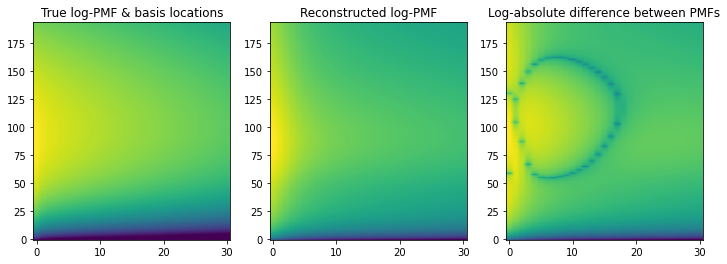

In [161]:
# plot individual PMF

p_num = 21

params[p_num]

tt.plot_PMF(params[p_num:p_num+1],ys[p_num],[10,10],model,get_ypred_at_RT_affine,metric)